In [1]:
# imports
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#####################
# my files
# target model
from net_ import target_net
#from net_conv import target_net
# gan architectures
import gans_archs
# advgan training class
from GAN_ import advGAN

if torch.cuda.is_available():  
    dev = 'cuda:0'
else:  
    dev = 'cpu'

print('device: ', dev)

# functions
def transform_data(data_loader_obj):
    ims = []
    lls = []
    for imgs,lbls in data_loader_obj:
        for img,lbl in zip(imgs,lbls):
            ims.append(img)
            lls.append(lbl)
    ims = torch.stack(ims)
    lls = torch.stack(lls)
    return ims,lls

device:  cuda:0


In [2]:
# obtain mnist data and process
batch_size = 128
num_of_classes = 2

def get_indices(dataset,ind_array):
    indices =  []
    for i in range(len(dataset.targets)):
        for ind in ind_array:
            if dataset.targets[i] == ind:
                indices.append(i)
    return indices

dataset = MNIST('.', train=True, download=False,transform=transforms.ToTensor())

idx = get_indices(dataset, np.arange(num_of_classes))
data_loader_target = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_gan = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))

classes = np.arange(num_of_classes)

In [3]:
# target model
n_estimators = 500
ims_train,lls_train = transform_data(data_loader_target)
rf = RandomForestClassifier(n_estimators=n_estimators)
#rf.fit(ims_train.reshape(len(ims_train),28*28).detach().numpy(),lls_train)
# save the model
PATH = './target_models/rf_model'+str(num_of_classes)+'classes'+'_nest'+str(n_estimators)+'.joblib'
#dump(rf, PATH) 
# load the model
rf = load(PATH)

# test random forest accuracy
ims_test,lls_test = transform_data(data_loader_gan)
print('accuracy: ', accuracy_score(rf.predict(ims_test.reshape(len(ims_test),28*28).detach().numpy()),lls_test))

accuracy:  1.0


In [6]:
# import gen/disc
gen = gans_archs.Generator1(include_noise=True,device=dev)
disc = gans_archs.Discriminator1()

# arguments for GAN training 
#target_net, gen, disc,
tar_criterion=nn.CrossEntropyLoss()
criterion=nn.BCEWithLogitsLoss()
n_epochs=200
batch_size=128
lr=0.00001
display_step=500
gen_arch='cov'
###############################
gen_arch_num=1
disc_coeff=2150.
hinge_coeff=250.
adv_coeff=900.
c=0.2
gen_path_extra='rftar_proba_noisevec_genarch_'+str(gen_arch_num)
shape=(1,28,28)
num_of_classes=num_of_classes
################################

# initiate advgan
advgan = advGAN(rf.predict_proba,gen,disc,tar_criterion=tar_criterion,
                criterion=criterion,n_epochs=n_epochs,
                batch_size=batch_size,num_of_classes=num_of_classes,
                lr=lr,disc_coeff=disc_coeff,hinge_coeff=hinge_coeff,
                adv_coeff=adv_coeff,c=c,gen_path_extra=gen_path_extra,
                device=dev,display_step=display_step,shape=shape,gen_arch=gen_arch)

path:  ./advgan_models/rftar_proba_noisevec_genarch_1_device_cuda:0_2classes_2150p0disc_250p0hinge_0p2c_900p0adv.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  5
Step 500: Generator loss: 2838.2110371142517, discriminator loss: 708.7713682556152
% wrong: 0.53125 | target model % correct: 1.0 | avg. frobenius norm: 4.229719638824463


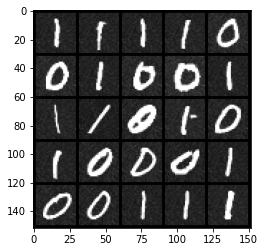

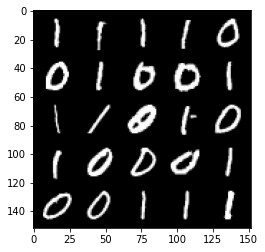

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  10
Step 1000: Generator loss: 1391.293399904809, discriminator loss: 105.50275250244137
% wrong: 0.515625 | target model % correct: 1.0 | avg. frobenius norm: 1.5310380458831787


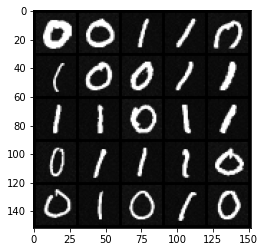

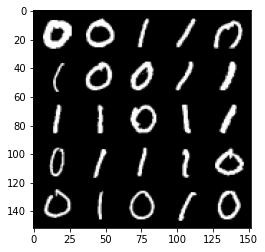

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  15
Step 1500: Generator loss: 1075.5990339436896, discriminator loss: 85.15454720306393
% wrong: 0.1796875 | target model % correct: 1.0 | avg. frobenius norm: 0.7533669471740723


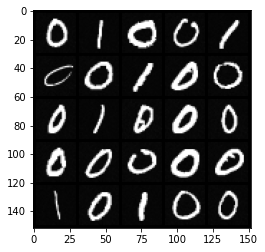

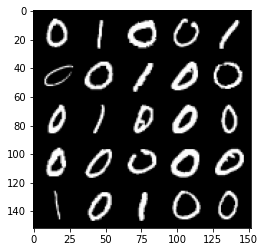

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  20
Step 2000: Generator loss: 997.6283350394584, discriminator loss: 94.24605005645755
% wrong: 0.0234375 | target model % correct: 1.0 | avg. frobenius norm: 0.4337925314903259


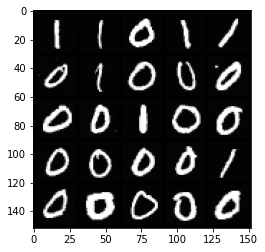

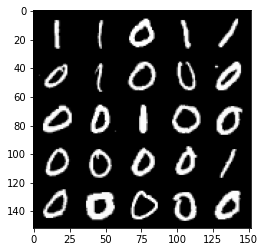

KeyboardInterrupt: 

In [7]:
%%time 
# train the gan
gen,disc = advgan.train(data_loader_gan)

In [ ]:
# notes
'''
When not concatenated with a noise vector, the robustness of the adv examples dies off. Results are illusrated 
in the form (epoch, % wrong, avg. frob. norm)
(5, 0.4, 4.4)
(25, 0.0, 0.29)
(40, 0.008, 0.15)
'''